In [ ]:
!pip install pyLDAvis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df_twitter = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Twitter')
df_ozbargain  = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Ozbargain')
df_whirlpool =  pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Whirlpool')
df_reddit = pd.read_excel("EV_community_discussion_data.xlsx", sheet_name='Reddit')

In [7]:
df_whirlpool.columns

Index(['id', 'post', 'date', 'source'], dtype='object')

In [8]:
df_whirlpool=df_whirlpool[['date','post']]

In [ ]:
df_whirlpool.head()

,date,post
0,2019-12-01,"Doesn't happen, due to the one thing people th..."
1,2019-12-01,"Then, of course, there are the (what is it, 45..."
2,2019-12-01,"Then, of course, there are the (what is it, 45..."
3,2019-12-01,Or maybe the guberment will have to make a rul...
4,2019-12-01,I say that simply noting that a large portion ...


In [9]:
df_whirlpool['date'] = pd.to_datetime(df_whirlpool['date'])
df_whirlpool['date'] = df_whirlpool['date'].dt.date

In [10]:
df_whirlpool['post'] =df_whirlpool['post'].str.lower()

In [ ]:
def remove_ids(post):
  mention_remove_post = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(post)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_remove_post)) # remove multiple spaces
  return spaces_removed


df_whirlpool['post'] =df_whirlpool['post'].apply(remove_ids)
df_whirlpool.tail()

In [12]:
duplicate_count = len(df_whirlpool['post'])-len(df_whirlpool['post'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df_whirlpool.shape[0])

duplicate count: 4
total records before remove duplicates: 2423


Whirlpool

In [13]:
df_whirlpool = df_whirlpool.drop_duplicates(subset='post', keep="first")
print('updated record count:', df_whirlpool.shape[0])

updated record count: 2419


In [14]:
df_whirlpool['post'] =df_whirlpool['post'].str.replace(r'[^\w\s]','')

In [ ]:
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

In [16]:
stop = stopwords.words('english')

In [ ]:
# Remove the words in 'stop' list
def remove_stop_words(post):
  tokens = post.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df_whirlpool['post'] =df_whirlpool['post'].apply(remove_stop_words)

df_whirlpool.tail(5)

In [18]:
from PIL import Image
from wordcloud import WordCloud

In [19]:
word_frequency_whirlpool = pd.Series(' '.join(df_whirlpool['post']).split()).value_counts()
word_frequency_whirlpool[:10]

car         1044
battery     1027
ev           942
would        826
evs          672
tesla        668
ice          629
cars         595
like         552
electric     520
dtype: int64

In [20]:
new_words_remove=['australia','going','would','electric','cars','car','electriccars','electricvehicle','ev','evs','like','electricvehicles','australias','dont','get','think','one','vehicles','thats','im','not']

In [21]:
df_whirlpool['post'] = df_whirlpool['post'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_remove))
word_frequency_whirlpool = pd.Series(' '.join(df_whirlpool['post']).split()).value_counts()
word_frequency_whirlpool[:10]

battery    1027
tesla       668
ice         629
years       469
people      433
price       431
model       409
range       402
even        397
new         394
dtype: int64

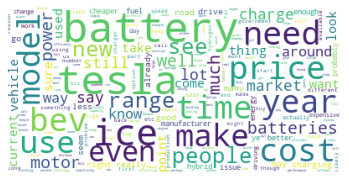

In [22]:
corpus_whirlpool = list(df_whirlpool['post'])

wordcloud_whirlpool = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus_whirlpool))

fig = plt.figure(1)
plt.imshow(wordcloud_whirlpool)
plt.axis('off')
plt.show()

In [31]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatization_function(sent):
  word_list = sent.split()
  lemmatized_word_list = [lemmatizer.lemmatize(word) for word in word_list]
  lemmatized_sentence = " ".join(lemmatized_word_list)
  return lemmatized_sentence

df_whirlpool['post'] = df_whirlpool['post'].apply(lemmatization_function)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [23]:
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [32]:
bigrams_df = get_ngrams(df_whirlpool['post'].tolist(), ngram_range=(2, 2))

In [33]:
#converting the bigrams to a dataframe
bigramsdf = pd.DataFrame(bigrams_df)
bigramsdf.columns=["Bi-gram", "Freq"]

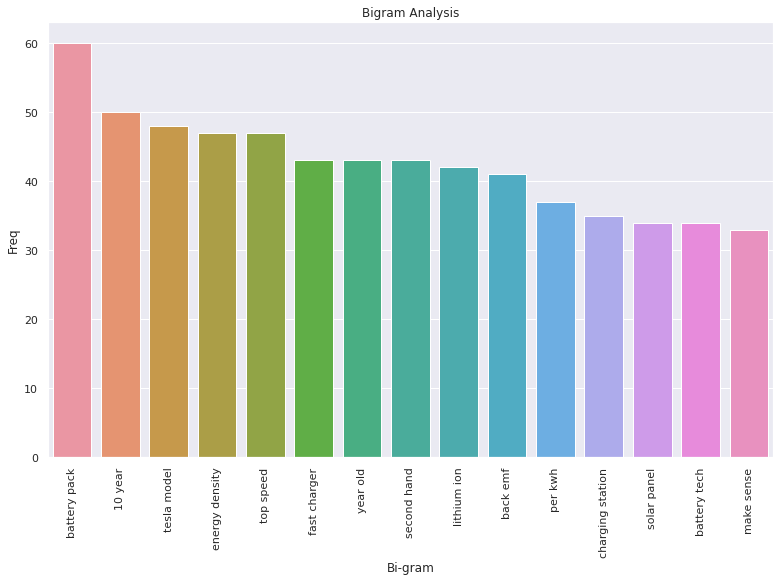

In [34]:
top_bigrams_to_show = 15

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigramsdf[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Bigram Analysis')
plt.show()

In [35]:
trigrams_df = get_ngrams(df_whirlpool['post'].tolist(), ngram_range=(3, 3))

In [36]:
#converting trigrams into a dataframe
trigramsdf = pd.DataFrame(trigrams_df)
trigramsdf.columns=["Tri-gram", "Freq"]

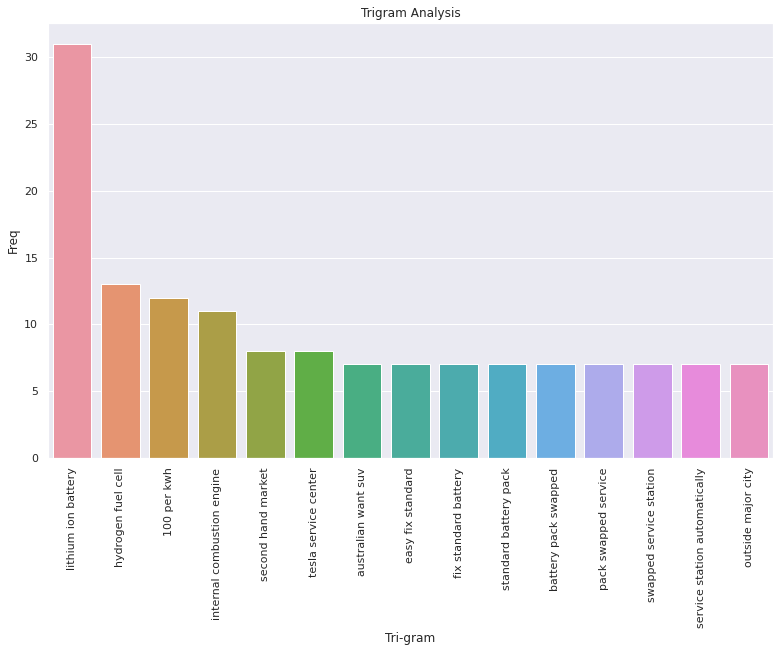

In [37]:
top_trigrams_to_show = 15

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigramsdf[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Trigram Analysis')
plt.show()


In [38]:
df_date_wise = df_whirlpool.groupby(['date'])['post'].count().reset_index(name='post_count')

In [39]:
#df_date_wise['date'] = pd.to_datetime(df_date_wise['date'])

In [ ]:
#reviews_month = df_date_wise.groupby(df_date_wise['date'].dt.strftime("%Y-%m"))['review_count_df'].sum()

In [40]:
reviews_month = df_date_wise.groupby(df_date_wise['date'])['post_count'].sum()

In [41]:
reviews_month

date
2019-12-01     77
2019-12-02     18
2019-12-03     13
2019-12-04      1
2019-12-05      1
             ... 
2020-03-07    121
2020-03-08     68
2020-03-09     96
2020-03-10     66
2020-03-11     11
Name: post_count, Length: 90, dtype: int64

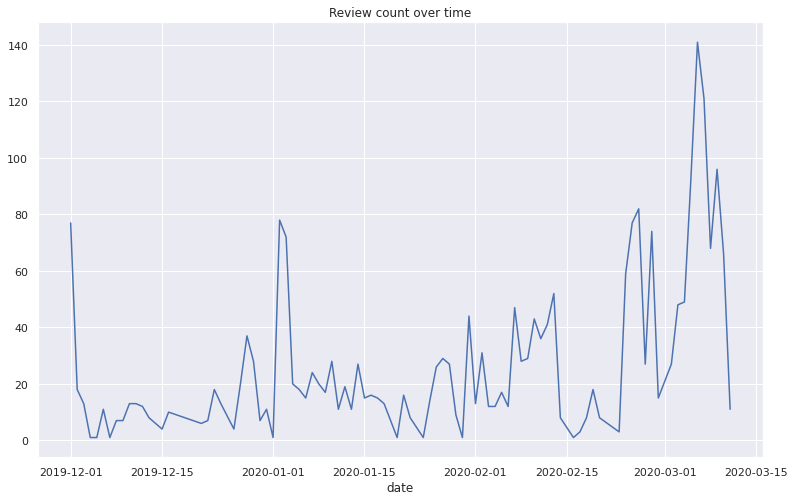

In [42]:
ax = reviews_month.plot()
plt.title('Review count over time')
plt.savefig('temporal_analysis_v2.png', dpi=800)

In [43]:
df_whirlpool['sentiment'] = df_whirlpool['post'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [44]:
dfsentiment = df_whirlpool[['date','sentiment']]

In [45]:
dfsentiment['date'] = pd.to_datetime(dfsentiment['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#df_sentiment = dfsentiment.groupby(dfsentiment['date'].dt.strftime("%Y-%m"))['sentiment'].mean()

In [46]:
df_sentiment_date_wise = df_whirlpool.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment_df').set_index('date')

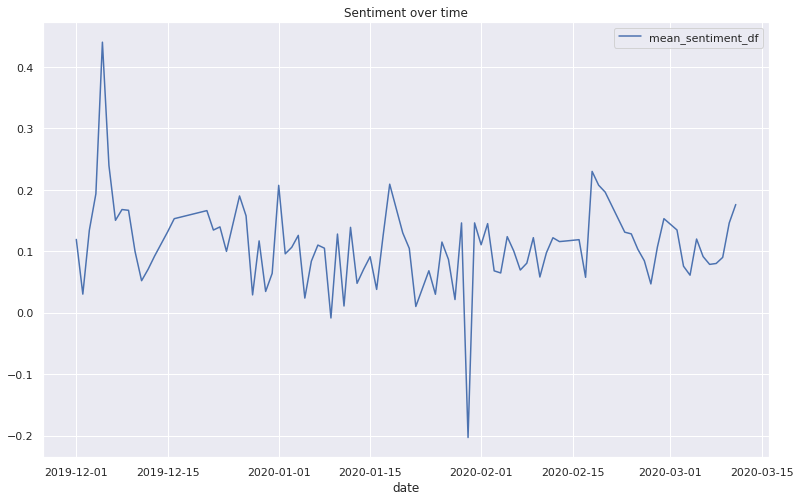

In [47]:
ax = df_sentiment_date_wise.plot()
plt.title('Sentiment over time')
plt.savefig('sentiment_v2.png', dpi=800)

In [ ]:
dfsentiment['date'] = pd.to_datetime(dfsentiment['date'])

In [ ]:
mask = (dfsentiment['date'] >= '2020-01-01') & (dfsentiment['date'] <= '2020-03-31')

In [ ]:
sentiment_JanMarch2020 = dfsentiment.loc[mask]

In [ ]:
sentiment_analysis = sentiment_JanMarch2020.groupby(sentiment_JanMarch2020['date'].dt.strftime("%b-%d"))['sentiment'].mean()

In [ ]:
plt.figure(figsize=(15, 4))
ax = sentiment_analysis.plot()

In [ ]:
df[['review', 'sentiment']].head(50)

In [49]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [50]:
corpus = list(df_whirlpool['post'])

In [51]:
df_texts = [[word for word in str(document).split()] for document in corpus]

In [52]:
dictionary = corpora.Dictionary(df_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'df.dict'))

2020-09-22 04:49:59,551 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-09-22 04:49:59,684 : INFO : built Dictionary(10722 unique tokens: ['1', '2', '5', '91', '98']...) from 2419 documents (total 104859 corpus positions)
2020-09-22 04:49:59,686 : INFO : saving Dictionary object under /tmp/df.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-09-22 04:49:59,697 : INFO : saved /tmp/df.dict


In [ ]:
print(df_texts[0])
print('alphabetically sorted', sorted(df_texts[0]))

['doesnt', 'happen', 'due', 'thing', 'people', 'money', 'well', 'disagree', 'say', 'simply', 'noting', 'large', 'portion', 'homes', 'tou', 'right', 'whilst', 'motivated', 'whatevers', 'cheapest', 'two', 'categories', 'others', '1', 'due', 'usage', 'gain', 'financially', 'changing', 'despite', 'cheaper', 'charging', '2', 'simply', 'arent', 'interested', 'saving', 'relatively', 'small', 'amount', 'money', 'wont', 'claim', 'hard', 'data', 'latter', 'theres', 'plenty', 'people', 'put', '98', 'ron', 'petrol', 'designed', '91', 'stay', '5', 'star', 'hotels', 'replace', 'perfectly', 'good', 'phones', 'new', 'ones', 'buy', 'new', 'every', 'year', 'two', 'wear', 'designer', 'brand', 'clothes', 'shop', 'expensive', 'retail', 'stores', 'saying', 'theres', 'anything', 'wrong', 'point', 'everyone', 'worried', 'cost', 'seems', 'rather', 'unlikely', 'people', 'worried', 'cost', 'charging', 'depending', 'many', 'could', 'well', 'lead', 'technically', 'undesirable', 'outcomes', 'thinking', 'therefore',

In [53]:
# Print the dictionary
print(dictionary.token2id)

{'1': 0, '2': 1, '5': 2, '91': 3, '98': 4, 'amount': 5, 'another': 6, 'anything': 7, 'approach': 8, 'arent': 9, 'around': 10, 'avoiding': 11, 'aware': 12, 'best': 13, 'brand': 14, 'buy': 15, 'came': 16, 'category': 17, 'changing': 18, 'charge': 19, 'charging': 20, 'cheaper': 21, 'cheapest': 22, 'claim': 23, 'close': 24, 'clothes': 25, 'concern': 26, 'concerned': 27, 'conscious': 28, 'cost': 29, 'could': 30, 'creates': 31, 'data': 32, 'decision': 33, 'default': 34, 'depending': 35, 'designed': 36, 'designer': 37, 'despite': 38, 'didnt': 39, 'disagree': 40, 'discussed': 41, 'doesnt': 42, 'due': 43, 'etc': 44, 'even': 45, 'every': 46, 'everyone': 47, 'expensive': 48, 'extensively': 49, 'financially': 50, 'gain': 51, 'get': 52, 'good': 53, 'grid': 54, 'happen': 55, 'hard': 56, 'home': 57, 'hotel': 58, 'interested': 59, 'involves': 60, 'issue': 61, 'large': 62, 'last': 63, 'latter': 64, 'lead': 65, 'least': 66, 'load': 67, 'looking': 68, 'manner': 69, 'many': 70, 'money': 71, 'motivated': 7

In [54]:
corpus = [dictionary.doc2bow(text) for text in df_texts]

In [55]:
review_id = 0
print(df_texts[review_id]) # each tweet converted to tokens
print(dictionary.doc2bow(df_texts[review_id])) # each token is represented as a id from a dictionary

['doesnt', 'happen', 'due', 'thing', 'people', 'money', 'well', 'disagree', 'say', 'simply', 'noting', 'large', 'portion', 'home', 'tou', 'right', 'whilst', 'motivated', 'whatevers', 'cheapest', 'two', 'category', 'others', '1', 'due', 'usage', 'gain', 'financially', 'changing', 'despite', 'cheaper', 'charging', '2', 'simply', 'arent', 'interested', 'saving', 'relatively', 'small', 'amount', 'money', 'wont', 'claim', 'hard', 'data', 'latter', 'there', 'plenty', 'people', 'put', '98', 'ron', 'petrol', 'designed', '91', 'stay', '5', 'star', 'hotel', 'replace', 'perfectly', 'good', 'phone', 'new', 'one', 'buy', 'new', 'every', 'year', 'two', 'wear', 'designer', 'brand', 'clothes', 'shop', 'expensive', 'retail', 'store', 'saying', 'there', 'anything', 'wrong', 'point', 'everyone', 'worried', 'cost', 'seems', 'rather', 'unlikely', 'people', 'worried', 'cost', 'charging', 'depending', 'many', 'could', 'well', 'lead', 'technically', 'undesirable', 'outcome', 'thinking', 'therefore', 'best', '

In [56]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2020-09-22 04:50:20,347 : INFO : collecting document frequencies
2020-09-22 04:50:20,350 : INFO : PROGRESS: processing document #0
2020-09-22 04:50:20,375 : INFO : calculating IDF weights for 2419 documents and 10721 features (88090 matrix non-zeros)


In [57]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

In [61]:
total_topics = 15

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

In [63]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      114.344879  114.308296       1        1  17.867895
0      105.821045  -93.749626       2        1  14.456597
14    -138.334473   95.320763       3        1  10.567782
11      -7.436697  111.259697       4        1   7.726158
6     -207.550629 -105.472603       5        1   6.067054
7       52.817650   14.603765       6        1   5.766997
4      168.010849    6.806950       7        1   5.503631
2      -94.169601 -157.789551       8        1   5.053782
3     -122.849174  -39.059418       9        1   4.512657
5      -94.894264  195.408295      10        1   4.489795
10      24.927401 -180.464874      11        1   4.104081
8      -53.413467   26.832108      12        1   3.699917
13     -12.255850  -72.093201      13        1   3.394686
12    -224.217957   28.070581      14        1   3.394526
9       36.154255  209.427582      15        1   3.394451, topic_info=          Term       Freq      Total Category  logprob  loglift
1370     motor  11.000000  11.000000  Default  30.0000  30.0000
485    battery  24.000000  24.000000  Default  29.0000  29.0000
974   software   5.000000   5.000000  Default  28.0000  28.0000
7082   gearing   2.000000   2.000000  Default  27.0000  27.0000
605        bev   9.000000   9.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
145       well   0.333637   7.299749  Topic15  -5.4679   0.2975
44         etc   0.323481   6.702743  Topic15  -5.4988   0.3519
536      range   0.334747   8.640413  Topic15  -5.4645   0.1322
311      power   0.307415   6.948897  Topic15  -5.5497   0.2649
30       could   0.280023   6.998612  Topic15  -5.6430   0.1644

[1118 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5581      1  1.380990  100kmh
2289      1  0.441410     200
2289      5  0.441410     200
1665      3  0.679620    2019
922       1  0.198486       3
...     ...       ...     ...
154      11  0.077503    year
446       1  0.235103     yes
446       2  0.235103     yes
446       4  0.235103     yes
344       3  0.456619     yet

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 15, 12, 7, 8, 5, 3, 4, 6, 11, 9, 14, 13, 10])